<a href="https://colab.research.google.com/github/psasanka1729/Ultimate-QM-MM/blob/main/shadow_tomography_qiskit_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit.quantum_info import Statevector
from qiskit import*

## Pauli matrices

In [ ]:
I2 = np.matrix([[1,0],
                [0,1]])
H  = np.matrix([[1,1],
                [1,-1]])* (1/np.sqrt(2))
S  = np.matrix([[1,0],
                [0,1j]])
X  = np.matrix([[0,1],
                [1,0]])
Y  = np.matrix([[0,-1j],
                [1j,0]])
Z  = np.matrix([[1,0],
                [0,-1]])

In [ ]:
def commutator(matrix_a,matrix_b):
    return matrix_a@matrix_b - matrix_b@matrix_a
def anti_commutator(matrix_a,matrix_b):
    return matrix_a@matrix_b + matrix_b@matrix_a

## Shadow tomography

In [ ]:
N_qubit = 2
# returns N*K classical shadows.
def classical_shadow_using_ST(N,K,theta_x,theta_y,theta_z,theta_ry):

    # setting up the quantum circuit
    qc = QuantumCircuit(N_qubit,1)
    # initializing the ancilla qubit at |0>.
    qc.initialize([1,0],0)
    qc.rx(theta_x,1)
    qc.ry(theta_y,1)
    qc.rz(theta_z,1)
    qc.cry(theta_ry,1,0)

    # qiskit returns the statevector as a row.
    # taking transpose to make it a column vector.
    sv = np.matrix(Statevector.from_instruction(qc)).T
    rho_SS = sv@(sv.conj().T)

    # number of shadows
    nShadows = N*K
    # number of shots
    number_of_shots = 1
    #rng = np.random.default_rng(1000)

    # number of qubits the Clifford gates will be applied to.
    N_clifford_qubit = 1
    cliffords = [qiskit.quantum_info.random_clifford(N_clifford_qubit) for _ in range(nShadows)]
    results = []

    r"""
     creating a empty circuit to compose to the Clifford circuit
     so that it becomes the same dimension as the original circuit."""
    for cliff in cliffords:
        # converting the clifford gates to circuit and appending it to the original circuit.
        qc_c  = cliff.to_circuit()
        qc  = qc.compose(qc_c,qubits=[1])
        qc.measure(1,0)
        # execute the quantum circuit
        backend = BasicAer.get_backend('qasm_simulator') # the device to run on
        result = backend.run(transpile(qc, backend), shots=number_of_shots).result()
        counts  = result.get_counts(qc)

        # samples the output in computational basis.
        #counts = qiskit.quantum_info.Statevector(qc_c).sample_counts(number_of_shots)

        results.append(counts)

    # performing rho_hat = (2**N+1)*(U^{\dagger}|b><b|U-I).
    shadow_lst = []
    # loops over the clifford gates and their corresponding measurement results.
    for cliff, res in zip(cliffords, results):
        # U^{\dagger} matrix.
        mat    = cliff.adjoint().to_matrix()
        for bit,count in res.items():
            try:
                bit = counts["0"]
            except KeyError:
                bit = counts["1"]

            if bit == "0":
                # |0>
                ket_b = np.matrix([[1],[0]])
            else:
                # |1>
                ket_b = np.matrix([[0],[1]])

            Ub = mat@ket_b
            #Ub = mat[:,int(bit,2)] # this is Udag|b>

            shadow_lst.append(((2**N_clifford_qubit+1.))*np.outer(Ub,(Ub.conj().T))*count - np.eye(2**N_clifford_qubit))
    return rho_SS, shadow_lst,qc

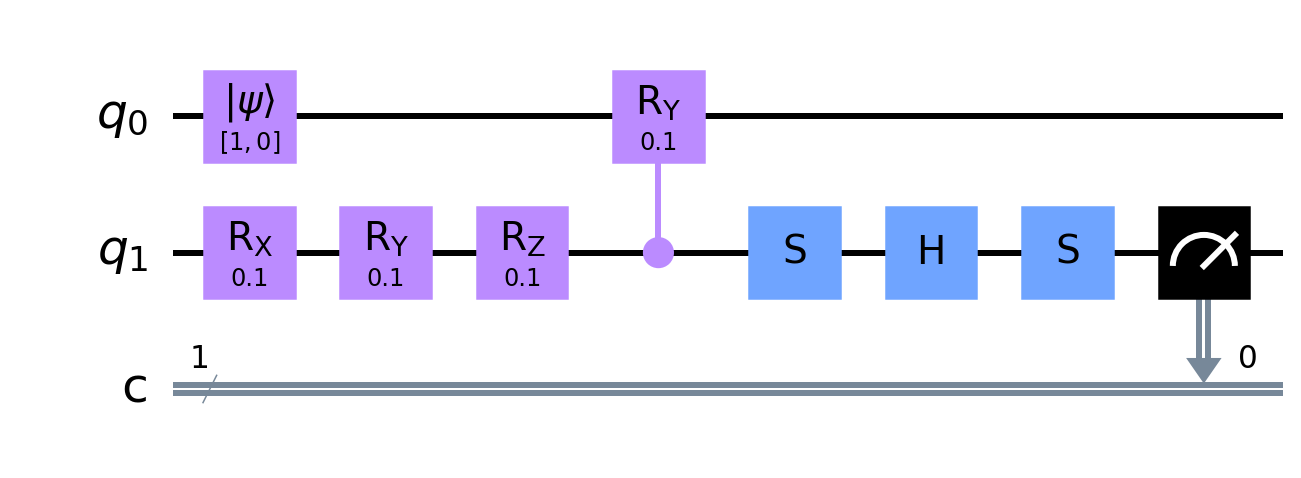

In [ ]:
classical_shadow_using_ST(1,1,0.1,0.1,0.1,0.1)[2].draw("mpl",scale=3,style="clifford")

## Parameters of Hamiltonian and Lindbladians

In [ ]:
b = 0.2
gamma_1 = 0.1
gamma_2 = 0.9

# known analytical solution
Delta = 2*b**2+gamma_1**2+4*gamma_1*gamma_2
yss= (2*b*gamma_1)/Delta
zss = (gamma_1*(gamma_1+4*gamma_2))/Delta

theta_y_exact = np.pi/8
theta_x_exact = np.arccos(zss/np.cos(theta_y_exact))
theta_z_exact = np.arctan(-np.sin(theta_y_exact)/np.tan(theta_x_exact))
theta_ry_exact = 2*np.arccos(-yss*np.cos(theta_z_exact)/np.sin(theta_x_exact))

print("theta_z = ",theta_z_exact)
print("theta_x = ",theta_x_exact)
print("theta_y = ",theta_y_exact)
print("theta_ry = ",theta_ry_exact)

theta_z =  -0.6414725691602342
theta_x =  0.4735237017488994
theta_y =  0.39269908169872414
theta_ry =  3.4552240242785945


In [ ]:
r"""

this function returns \mathcal{L}\rho i.e. the right hand side of the
Lindblad equation.

input: density matrix (either exact or shadow), list of Lindbladians.
output: right hand side of the Lindblad equation.

"""

def partial_trace(mat):
    return np.matrix([[mat[0,0]+mat[1,1],mat[0,2]+mat[1,3]],
                      [mat[2,0]+mat[3,1],mat[2,2]+mat[3,3]]])

# the parameter that should be changed is the density_mat
def lindblad_equation(density_mat, hamiltonian = -(b/2)*X,
                      L_1 = np.sqrt(gamma_1)*np.matrix([[0,1],[0,0]]),
                      L_2 = np.sqrt(gamma_2)*Z):
    # reduced density matrix for the state
    #rho_state = partial_trace(density_mat)
    return (-1j*commutator(hamiltonian,density_mat)
            + L_1@density_mat@(L_1.conj().T) - (1/2)*anti_commutator((L_1.conj().T)@L_1,density_mat)
            + L_2@density_mat@(L_2.conj().T) - (1/2)*anti_commutator((L_2.conj().T)@L_2,density_mat))

In [ ]:
# density matrix in terms of angles
def rho_SS_from_angles(theta_x,theta_y,theta_z,theta_ry):
    rho_11 = (1/2)*(1+np.cos(theta_x)*np.cos(theta_y))
    rho_12 = ((1/2)*np.exp(-1j*theta_z)*np.cos(theta_ry/2)*(np.sin(theta_y)*np.cos(theta_x)
                                                           +1j*np.sin(theta_x)))
    return np.matrix([[rho_11,rho_12],[rho_12.conj(),1-rho_11]])

# analytical solution from literature.
rho_SS_analytical = (1/2)*(I2+yss*Y+zss*Z)
rho_SS_analytical

matrix([[0.91111111+0.j        , 0.        -0.04444444j],
        [0.        +0.04444444j, 0.08888889+0.j        ]])

In [ ]:
# density matrix in terms of angles to verify that calculations
# in variation of parameters are correct
rho_SS_from_angles(theta_x_exact,theta_y_exact,theta_z_exact,theta_ry_exact)

matrix([[ 9.11111111e-01+0.j        , -6.93889390e-18-0.04444444j],
        [-6.93889390e-18+0.04444444j,  8.88888889e-02+0.j        ]])

In [ ]:
lindblad_equation(rho_SS_analytical)

matrix([[0.00000000e+00+0.j, 0.00000000e+00+0.j],
        [0.00000000e+00+0.j, 1.38777878e-17+0.j]])

In [ ]:
rho_exact_from_qiskit = classical_shadow_using_ST(1,1,theta_x_exact,theta_y_exact,theta_z_exact,theta_ry_exact)[0]

In [ ]:
rho_SS_from_qiskit = partial_trace(rho_exact_from_qiskit)
print("rho_SS from qiskit = ", rho_SS_from_qiskit)

rho_SS from qiskit =  [[ 9.11111111e-01+0.j         -1.73472348e-18-0.04444444j]
 [-1.73472348e-18+0.04444444j  8.88888889e-02+0.j        ]]


In [ ]:
L_rho = lindblad_equation(rho_SS_from_qiskit)
L_rho

matrix([[ 1.11022302e-16+0.00000000e+00j,
          3.20923843e-18-8.32667268e-17j],
        [ 3.20923843e-18+8.32667268e-17j,
         -1.38777878e-17+0.00000000e+00j]])

In [ ]:
#rho_SS_shadow = classical_shadow_using_ST(10,10,theta_x_exact,theta_y_exact,theta_z_exact,theta_ry_exact)[1]

## Median of means estimator

In [ ]:
# linear function
def linear_o_k(O_i,k,shadow_lst):
    s = 0.0
    for j in range(N*(k-1)+1,N*k+1):
        rho_j = shadow_lst[j-1]
        s += np.trace(O_i@rho_j)
    return s/N

def linear_o(O_i,shadow_lst):
    linear_o_k_lst = []
    for kk in range(1,K+1):
        linear_o_k_lst.append(linear_o_k(O_i,kk,shadow_lst))
    return np.median(linear_o_k_lst)

# quadratic function
SWAP_matrix = np.matrix([[1,0,0,0],
                  [0,0,1,0],
                  [0,1,0,0],
                  [0,0,0,1]])

# f(\rho) = \tr(X_i rho X_j \rho)
X_i = X
X_j = Y
O_i = SWAP_matrix@np.kron(X_i,X_j)

# median of means method to estimate the cost function
def quadratic_o_k(k,shadow_lst):
    s = 0.0
    for j in range(N*(k-1)+1,N*k+1):
        for l in range(N*(k-1)+1,N*k+1):
            if j != l:
                rho_j = shadow_lst[j-1]
                rho_l = shadow_lst[l-1]
                # cost function
                s += np.trace(O_i@(np.kron(rho_j,rho_l)))
    return s/(N*(N-1))

# following function returns the estimated cost function
def quadratic_o(shadow_lst):
    o_k_lst = []
    for kk in range(1,K+1):
        o_k_lst.append(o_k(kk,shadow_lst))
    return np.median(o_k_lst)

## Cost function using shadow tomography

In [ ]:
def cost_function_using_shadow_tomography(N,K,theta_x_angle,theta_y_angle,theta_z_angle,theta_ry_angle):

    # performing shadow tomography
    ST = classical_shadow_using_ST(N,K,theta_x_angle,theta_y_angle,theta_z_angle,theta_ry_angle)
    rho_exact_from_qiskit = ST[0]
    rho_shadow_lst_from_qiskit = ST[1]

    rho_SS_shadow_from_qiskit_lst = []
    # tracing over the system to obtain the system density matrix
    #for full_density_matrix in rho_shadow_lst_from_qiskit:
        #rho_SS_shadow_from_qiskit_lst.append(partial_trace(full_density_matrix))

    # exact value of the cost function
    exact_cost_function = np.trace(X@partial_trace(rho_exact_from_qiskit))
    #exact_cost_function = np.trace((lindblad_equation(rho_exact_from_qiskit))**2)

    return linear_o(X,rho_shadow_lst_from_qiskit),exact_cost_function

In [ ]:
print("theta_z = ",theta_z_exact)
print("theta_x = ",theta_x_exact)
print("theta_y = ",theta_y_exact)
print("theta_ry = ",theta_ry_exact)

theta_z =  -0.6414725691602342
theta_x =  0.4735237017488994
theta_y =  0.39269908169872414
theta_ry =  3.4552240242785945


In [ ]:
delta = 0.01
K = 2*np.log(2*1/delta)
print(K)
epsilon = 0.01
N = (34/epsilon**2)
print(N)

10.596634733096073
340000.0


In [ ]:
divisons = 50
angles_lst = np.linspace(-np.pi,np.pi,divisons)

def cost_function(rho):
    return np.trace(rho@rho)

cost_function_array_shadow = np.zeros(divisons)
cost_function_array_exact= np.zeros(divisons)
N = 70
K = 10
for jj in range(divisons):
    cost_functions = cost_function_using_shadow_tomography(N,K,angles_lst[jj],
                                                           theta_y_exact,
                                                           theta_z_exact,
                                                           theta_ry_exact)
    cost_function_array_shadow[jj] = cost_functions[0].real
    cost_function_array_exact[jj]  = cost_functions[1].real

In [ ]:
large = 40; med = 20; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'
plt.rcParams.update(params)
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)
plt.plot(angles_lst,cost_function_array_exact,c="red",label="exact")
plt.plot(angles_lst,cost_function_array_shadow,c="blue")
plt.scatter(angles_lst,cost_function_array_shadow,c="blue",label="shadow")

ax = f.gca()
#ax.axvline(theta_x_exact, color="green",label=r"Exact $\theta_{x}$",linestyle="--")
ax.axhline(0, color="k",linestyle="--",alpha=0.5)
#ax.axvline(-np.pi+theta_x_exact, color="green",label = r"$\theta_{x}$",linestyle="--")
#plt.title("Plot of cost function, "+r"$f( \rho ) = \textrm{tr}((\mathcal{L}\rho)^{2})$")
plt.title("N = "+str(N*K))
plt.xlabel(r"$\theta_{x}$")
plt.ylabel(r"tr$( X \rho )$")
#plt.ylim([-0.25,0.25])
plt.legend()
plt.gcf().subplots_adjust(bottom=0.2)
plt.gcf().subplots_adjust(left=0.2)
#plt.savefig("f_as_function_of_theta_x_6000.jpg",dpi=600)
plt.show()

In [ ]:
r"""
rho_exact_and_shadows = classical_shadow_using_ST(100,10,theta_x_exact,theta_y_exact,theta_z_exact,theta_ry_exact)
rho_exact = rho_exact_and_shadows[0]
rho_shadow = np.sum(rho_exact_and_shadows[1],axis=0)/(len(rho_exact_and_shadows[1]))""";

In [ ]:
r"""
large = 40; med = 20; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams['text.usetex'] = False
plt.rcParams.update(params)
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(2, 2)
fig.set_figwidth(8)
fig.set_figheight(8)

c1 = axs[0, 0].imshow(rho_exact.real)
axs[0, 0].set_title(r"Exact Re$[\rho]$")

c2 = axs[0, 1].imshow(rho_shadow.real)
axs[0, 1].set_title(r"Shadow Re$[\rho]$")

c3 = axs[1, 0].imshow(rho_exact.imag)
axs[1, 0].set_title(r"Exact Im$[\rho]$")

c4 = axs[1, 1].imshow(rho_shadow.imag)
axs[1, 1].set_title(r"Shadow Im$[\rho]$")

plt.suptitle("N = "+str(len(rho_exact_and_shadows[1])))

#for ax in axs.flat:
    #ax.set(xlabel='x-label', ylabel='y-label')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(c4, cax=cax, orientation='vertical')

# Display the figure with subplots
plt.tight_layout()
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.tight_layout()
plt.savefig("density_matrix_comparison_"+str(len(rho_exact_and_shadows[1]))+".jpg", dpi=600)
plt.show()""";